In [1]:
# =======================================================================================================
# Code was runned using Docker on top of Ubuntu 22.04.1 LTS with Nvidia drivers 510. 
# Image: tensorflow/tensorflow:latest-gpu-jupyter
# CUDA version: 11.6 
# =======================================================================================================
# Run with: 
#        docker pull tensorflow/tensorflow:latest-gpu-jupyter
#        docker run --rm -it --gpus 0 --name=pong_tensorflow -p8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
# =======================================================================================================
# In another shell:
#        docker cp A3C-Pong.ipynb pong_tensorflow:/tf/
# Accessing from browser, uncomment the code below to install all the proper software. 
# Re-comment it as soon as it finishes.
# =======================================================================================================
# Access output file with another shell:
#        docker exec -it pong_tensorflow bash
#        # tail -f Pong/output.txt
# =======================================================================================================

In [2]:
# =======================================================================================================
#!apt-get update
#!apt-get install -y xvfb ffmpeg cmake wget unrar python-opengl x11-utils
#!apt-get upgrade --yes 
#
#!pip install --upgrade pip
#!pip install gym[atari] opencv-python atari-py pyglet pyvirtualdisplay ale-py lz4 gym-notebook-wrapper --upgrade
# =======================================================================================================
#!SHELL=/bin/bash
#!if [ ! -f 'Roms.rar' ] ; then wget http://www.atarimania.com/roms/Roms.rar ; unrar e Roms.rar ; fi
#!python -m atari_py.import_roms . 
# =======================================================================================================

In [3]:
# =======================================================================================================
import os
import time
import matplotlib
import cv2
import gym
import gnwrapper
import time
import multiprocessing
import pickle
import shutil
# =======================================================================================================
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
# =======================================================================================================
from time                import gmtime, strftime
from collections         import deque
from gym                 import envs
from gym.wrappers        import FrameStack, GrayScaleObservation, ResizeObservation, AutoResetWrapper
from tensorflow          import keras
from keras               import backend
from threading           import Thread, Lock
from queue               import Queue
from typing              import List, Tuple
# =======================================================================================================

In [4]:
# =======================================================================================================
# tf.keras.backend.set_floatx('float32') # set keras default floating point precision type
tf_fpp = tf.float32                      # tf floating point precision type 
np_fpp = np.float32                      # np floating point precision type
tf.keras.backend.clear_session()
# =======================================================================================================

In [5]:
# =======================================================================================================
maximum_number_of_workers = 64           # Single out-of-context variable to specify the maximum number of 
                                         # threads to run in parallel. This because of the creation of an array
                                         # of environments in used in a **static** context in order to apply 
                                         # the @tf.function annotation and speed up the whole process.
            
                                         # Otherwise, calls to functions of non-static variables in an OO 
                                         # context would've required the *self* starting argument, not 
                                         # convertible to a Tensor, therefore not allowing the conversion to graph.
# =======================================================================================================

In [6]:
# =======================================================================================================
# CropObservation wrapper crops the image(s) in input to a specified dimension. 
# =======================================================================================================
class CropObservation(gym.ObservationWrapper):

    def __init__(self, environment, kwargs):
        super().__init__(environment)
        self.x_low  = kwargs["x_low"]
        self.x_high = kwargs["x_high"]
        self.y_low  = kwargs["y_low"]
        self.y_high = kwargs["y_high"]

    def observation(self, observation):
        observation = observation[self.y_low:self.y_high, self.x_low:self.x_high]
        return observation
# =======================================================================================================

# =======================================================================================================
# DenoiseObservation wrapper uses computer vision's adaptive threshold function to highlight important features.
# Original function documentation can be found here [https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html]
# =======================================================================================================
class DenoiseObservation(gym.ObservationWrapper):
  
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, observation):
        observation = cv2.adaptiveThreshold(observation, 255., cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)
        return observation
# =======================================================================================================
  
    
# =======================================================================================================
# NormalizeObservation wrapper divides the uint8 pixels by their max value (255.) in order to scale it to a value
# between 0 and 1. This reduces the variance of values in the neural network.
# =======================================================================================================
class NormalizeObservation(gym.ObservationWrapper):
    
    def __init__(self, environment):
        super().__init__(environment)
        
    def observation(self, observation):
        observation = tf.cast(observation, dtype=tf.float32)
        observation = tf.divide(observation, 255.)
        return observation
# =======================================================================================================

# =======================================================================================================
# Function that, based on the arguments passed in the last section, automatically wraps the environment 
# =======================================================================================================
def make_env(kwargs):
    
    env = gym.make(env_name, render_mode=kwargs["render_mode"], frameskip=kwargs["frameskip"], 
             repeat_action_probability=kwargs["repeat_probability"], difficulty=kwargs["difficulty"])
    env = AutoResetWrapper(env)
    
    if kwargs["crop"]:
        env = CropObservation(env, kwargs)
    if kwargs["grayscale"]:
        env = GrayScaleObservation(env, keep_dim=True)
    if kwargs["resize"]:
        env = ResizeObservation(env, (kwargs["screen_size"], kwargs["screen_size"]))
    if kwargs["denoise"]:
        env = DenoiseObservation(env)
    if kwargs["normalize"]: 
        env = NormalizeObservation(env)
    if kwargs["stack_frames"]:
        env = FrameStack(env, kwargs["n_frames"])

    return env
# =======================================================================================================

In [7]:
# =======================================================================================================
# Actor-Critic model as specified in the original A3C paper in section 8 (Experimental Setup) of the 
# supplementary material.
# A possible extension to the neural network would be to add LSTM cells to this architecture. 
# Another possible extension would be to directly use ConvLSTM2D layers offered by tensorflow.
#
# When experiencing fading gradients, it's adviced to switch the activation to leaky_relu.
# 
# Technically, the actor layer's function activation should be a softmax. The reason to postpone the softmax 
# operation to later stages is intended: as reported in an older documentation, it should be more numerically 
# stable. Or at least it was. 
# [https://github.com/tensorflow/tensorflow/blob/4f50b5dc6426f63a8e70b65d3b9e55ed8f7d38e2/tensorflow/python/keras/losses.py#L437]
# =======================================================================================================

class ActorCriticModel(tf.keras.Model):
    
    def leaky_relu(self, x):
        return tf.keras.activations.relu(x, alpha=self.alpha, max_value=None, threshold=0.0)
        
    def __init__(self, state_shape, action_size):

        self.alpha = 1/16.0
        
        self.state_shape     = state_shape
        self.action_size     = action_size

        inputs           = tf.keras.layers.Input(shape=self.state_shape)
        conv_1           = tf.keras.layers.Conv2D(8, 8, strides=2, activation='relu', kernel_initializer='he_uniform') (inputs)
        conv_2           = tf.keras.layers.Conv2D(16, 4, strides=2, activation='relu', kernel_initializer='he_uniform') (conv_1)
        conv_3           = tf.keras.layers.Conv2D(32, 2, strides=4, activation='relu', kernel_initializer='he_uniform') (conv_2)
        flatten          = tf.keras.layers.Flatten() (conv_3)
        dense_1          = tf.keras.layers.Dense(units=1024, activation=self.leaky_relu) (flatten)
        critic           = tf.keras.layers.Dense(units=1) (dense_1)
        actor            = tf.keras.layers.Dense(units=action_size) (dense_1) 

        super(ActorCriticModel, self).__init__(inputs=inputs, outputs=[actor, critic])



In [8]:
# =======================================================================================================
# GlobalUpdater is the delegate that the asynchronous Worker uses to communicate with Controller.
# It's called Global Updater because allows the update of the global model, held by Controller.
# =======================================================================================================
class GlobalUpdater():
    
    def __init__(self, controller_queue, worker_queue):
        self.controller_queue = controller_queue
        self.worker_queue = worker_queue
    # =======================================================================================================            
    # Operation to signal the controller the completion of an episode. It simply communicates all the variables 
    # needed to log the episode. 
    # =======================================================================================================
    def episode_completion_update(self):
        self.controller_queue.put(("completion", ()))
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Operation to signal the update of the global model. Gradients are sent through the queue to the Controller
    # so that he can apply gradients using its optimizer.
    # Returns: the updated global model weights to substitute the local model ones with.
    # =======================================================================================================
    def global_model_update(self, worker_idx, grads):
        self.controller_queue.put(("update", (worker_idx, grads)))
        return self.worker_queue.get()
    # =======================================================================================================
    
    # =======================================================================================================
    # Operation to request the global episode variable, held by Controller.
    # =======================================================================================================
    def get_global_episode(self, worker_idx):
        self.controller_queue.put(("get_episode", (worker_idx,)))
        return self.worker_queue.get()
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Operation to request the weights of Controller's global model so to initialize every Worker's local model
    # to have the correct initial weights.
    # =======================================================================================================
    def get_weights(self, worker_idx):
        self.controller_queue.put(("get_weights", (worker_idx,)))
        return self.worker_queue.get()
    # =======================================================================================================
    
    # =======================================================================================================
    # Operation to signal the Controller the reaching of the termination state of the worker. Termination state
    # occurs when the global episode is larger than the maximum number of episodes to train the model
    # =======================================================================================================            
    def signal_termination(self):
        self.controller_queue.put(None)
    # =======================================================================================================
        

In [9]:
# =======================================================================================================
# As specified above, this variable holds the static array accessed by Worker in a way that is compatible with
# @tf.function annotation. This speeds up the training process by a lot.
# =======================================================================================================

envs = [None] * maximum_number_of_workers


class Worker(Thread):
    # =======================================================================================================
    def __init__(self, worker_idx, updater, state_shape, kwargs):
        super(Worker, self).__init__()
        # Worker's identifier
        self.worker_idx           = worker_idx
        # State shape to initialize the ActorCriticModel class with
        self.state_shape          = state_shape
        # Updater to communicate with the Controller
        self.updater              = updater
        # Private Worker environment stored in a static array as specified above
        # self.env                  = make_env(kwargs)
        envs[self.worker_idx]     = make_env(kwargs)
        # Name of the environment to explore
        self.env_name             = kwargs["env_name"]
        # Set of available actions that the Worker can perform during its exploration
        self.available_actions    = kwargs["available_actions"]
        self.action_size          = len(self.available_actions)
        # Local ActorCriticModel used to explore and process gradients 
        self.local_model          = ActorCriticModel(self.state_shape, self.action_size)

        
        # Losses used to train the model. As mentioned above, both actor loss and entropy loss have the 
        # from_logits variable set to False for better stability
        # Entropy loss can be calculated as the crossentropy with labels = true_values = probs
        reduction                 = tf.keras.losses.Reduction.NONE
        self.actor_loss_fn        = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=reduction)
        self.critic_loss_fn       = tf.keras.losses.MeanSquaredError(reduction=reduction)
        self.entropy_loss_fn      = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=reduction)
        
        # Hyperparams
        self.max_eps              = kwargs["max_eps"]
        self.update_freq          = kwargs["update_freq"]
        self.gamma                = kwargs["gamma"]
        self.exponential_discount = kwargs["exponential_discount"]
        self.entropy_factor       = kwargs["entropy_factor"]
        self.critic_loss_factor   = kwargs["critic_loss_factor"]
        self.eps                  = kwargs["eps"]
        
        print(f'Worker [{self.worker_idx}] started.')
    # =======================================================================================================

        
    # =======================================================================================================
    # Each of the following static methods is nothing else than a method that explicitly or implicitly use a 
    # Numpy function and its own tensorflow wrapper. This operation is being done to allow graph mode execution
    # via the usage of @tf.function annotation.
    # =======================================================================================================
    
    # =======================================================================================================
    @staticmethod
    def env_reset(index):
        new_state, info = envs[index].reset()
        return np.array(new_state, np_fpp)

    @staticmethod
    def tf_env_reset(index):
        return tf.numpy_function(Worker.env_reset, [index], tf_fpp)
    # =======================================================================================================
    
    
    # =======================================================================================================
    @staticmethod
    def env_step(index, action):
        new_state, reward, done, truncated, info = envs[index].step(action)
        return (np.array(new_state, np_fpp), np.array(reward, np_fpp), np.array(done, np_fpp))

    @staticmethod
    def tf_env_step(index, action):
        return tf.numpy_function(Worker.env_step, [index, action], [tf_fpp, tf_fpp, tf_fpp])
    # =======================================================================================================

    
    # =======================================================================================================
    @staticmethod
    def get_action(available_actions, action_index):
        return available_actions[action_index].astype(np.uint8)

    @staticmethod
    def tf_get_action(available_actions, action_index):
        return tf.numpy_function(Worker.get_action, [available_actions, action_index], tf.uint8)
    # =======================================================================================================
    
    
    # =======================================================================================================
    # This function explores the environment by playing for n steps. It stores every variable needed to 
    # calculate the gradient onto their own TensorArray, then proceeds to stack before passing them to the 
    # loss function. The 'set_shape' methods are used to preserve the variable shape across different 
    # iterations of the for loop.
    #
    # The bootstrapped value is calculated as specified in the paper:
    # - 0        if state is a terminal state.
    # - V(state) if state is not a terminal state.
    #
    # It's important to notice that this function is working while in a tf.GradientTape context. Therefore,
    # the model is only called in this function and values are stored, so there's no need to call once more
    # the model while in the function that calculates the total loss. 
    # =======================================================================================================
    def play_steps(self, state):
        
        logits     = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        values     = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        rewards    = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        dones      = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        actions    = tf.TensorArray(dtype=tf.uint8, size=0, dynamic_size=True)
        
        for t in tf.range(self.update_freq):

            logit, value        = self.local_model(state)
            
            action_index        = tf.cast(tf.squeeze(tf.random.categorical(logit, 1)), tf.uint8)
            action              = Worker.tf_get_action(self.available_actions, action_index)
            
            state, reward, done = Worker.tf_env_step(self.worker_idx, action)

            reward              = tf.convert_to_tensor(reward, dtype=tf_fpp)
            state               = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            
            logits              = logits.write(t, logit)
            values              = values.write(t, value)
            rewards             = rewards.write(t, reward)
            dones               = dones.write(t, done)
            actions             = actions.write(t, action_index)
            
        # Bootstrap last state
        _, value = self.local_model(state)
        values   = values.write(t + 1, value)
            
        return logits.stack(), values.stack(), rewards.stack(), dones.stack(), actions.stack(), state
    # =======================================================================================================
    
    # =======================================================================================================
    # Function to process rewards and calculate the standard target values to update the value function and
    # estimate advantages.
    # =======================================================================================================
    def get_expected_returns(self, values, dones, rewards):
        
        expected_return = values[-1]
        expected_return_shape = expected_return.shape
        expected_returns = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        
        for t in tf.reverse(tf.range(self.update_freq), axis=[0]): 
            expected_return = (1.0 - dones[t]) * rewards[t] + self.gamma * expected_return
            expected_return.set_shape(expected_return_shape)
            expected_returns = expected_returns.write(t, expected_return)
            
        return tf.expand_dims(expected_returns.stack(), axis=-1)
    # =======================================================================================================
    
    # =======================================================================================================
    # Function to process rewards and calculate Generalized Advantage Estimates as proposed in the 
    # "High-Dimensional Continuous Control Using Generalized Advantage Estimation" paper. Using this should 
    # improve learning with respect to the standard advantage estimation. 
    # =======================================================================================================
    def get_generalized_advantage_estimate(self, values, dones, rewards): 
        
        next_advantage   = tf.constant(0.0, dtype=tf_fpp)
        next_adv_shape   = next_advantage.shape
        advantages       = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        
        values           = tf.squeeze(values, axis=1)
        
        next_values      = values[1:]
        values           = values[:self.update_freq]
        
        for t in tf.reverse(tf.range(self.update_freq), axis=[0]):

            delta          = rewards[t] + (self.gamma * (1.0 - dones[t]) * next_values[t]) - values[t]
            next_advantage = delta + (self.gamma * self.exponential_discount * (1.0 - dones[t]) * next_advantage)
            
            next_advantage.set_shape(next_adv_shape)
            advantages     = advantages.write(t, next_advantage)
        
        return advantages.stack()
    # =======================================================================================================

    
    # =======================================================================================================
    # Computes the total loss of the trajectory experienced through the function play_steps. 
    # Depending on hyperparameters, one can either use standard advantage estimate or the general one. 
    # Furthermore, it's possible to clip rewards (to values [-1, 0, 1]) and to normalize advantages.
    # The single loss functions used in this function do match the expected behavior:
    # * actor   = - reduce_mean(reduce_sum(log(probs[action], axis=1))
    # * entropy = - reduce_mean(reduce_sum(log(probs) * probs, axis=1))
    # * critic  = reduce_mean((value_targets - values) ** 2)
    #
    # Since the gradient tape wraps the play_steps and the advantage estimation functions, it's mandatory to
    # stop gradients earlier. Furthermore, the stop_gradient function has been applied to actions as well 
    # since the softmax_sparse_categorical_crossentropy_v2 function defined by tensorflow propagates gradients
    # to true values as well and it's not clear whether this function is used in the SparseCategoricalCrossEntropy
    # wrapper. 
    # ======================================================================================================= 
    def compute_loss(self, logits, values, rewards, dones, actions):
        
        logits         = tf.squeeze(logits, axis=1)
        values         = tf.squeeze(values, axis=1)
    
        advantages     = self.get_generalized_advantage_estimate(values, dones, rewards)
        value_targets  = self.get_expected_returns(values, dones, rewards)
        
        values         = values[:self.update_freq]
        # value_targets  = tf.expand_dims(advantages, axis=1) + values
        
        actions        = tf.stop_gradient(actions)
        advantages     = tf.stop_gradient(advantages)
        actor_loss     = self.actor_loss_fn(y_true=actions, y_pred=logits, sample_weight=advantages)

        value_targets  = tf.stop_gradient(value_targets)
        critic_loss    = self.critic_loss_factor * self.critic_loss_fn(y_true=value_targets, y_pred=values) 
        
        probs          = tf.nn.softmax(logits + self.eps)
        entropy        = - self.entropy_factor * self.entropy_loss_fn(y_true=probs, y_pred=logits)  

        total_loss     = tf.reduce_mean(actor_loss + entropy + critic_loss, axis=0)
                
        return total_loss
    # =======================================================================================================

    
    # =======================================================================================================
    # Basic tf.function wrapper to encapsulate both play_steps and compute_loss function
    # =======================================================================================================
    @tf.function    
    def step(self, state):
        with tf.GradientTape() as tape:
            (logits, 
             values, 
             rewards, 
             dones,
             actions, 
             state)    = self.play_steps(state)
            
            total_loss = self.compute_loss(logits, values, rewards, dones, actions)

        grads = tape.gradient(total_loss, self.local_model.trainable_weights)
            
        if tf.reduce_sum(dones) > 0:
            done = tf.constant(True, dtype=tf.bool)
        else:
            done = tf.constant(False, dtype=tf.bool)
            
        return state, done, grads
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Function that wraps all the behavior expected from the Worker. It initializes the states and 
    # communicates to Controller through GlobalUpdater both the gradients and the variables to be logged. 
    # =======================================================================================================
    def run(self):
        
        # Initialize weights with global model ones
        self.local_model.set_weights(self.updater.get_weights(self.worker_idx))
        
        state = tf.convert_to_tensor(Worker.env_reset(self.worker_idx), dtype=tf_fpp)
        state = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
        
        self.episode = self.updater.get_global_episode(self.worker_idx)
        
        while self.episode < self.max_eps:
            state, done, grads = self.step(state)

            # Push local gradients to global model
            self.local_model.set_weights(self.updater.global_model_update(self.worker_idx, grads))

            if done: 
                # Signal completion to Controller
                self.updater.episode_completion_update()
                
            self.episode = self.updater.get_global_episode(self.worker_idx)

        self.updater.signal_termination()
    # =======================================================================================================


In [10]:
class Saver():
    def __init__(self, save_dir, checkpoint):
        # Directories and files where the progress is saved into
        self.save_dir = save_dir
        self.checkpoint = checkpoint
        
        self.output_file = save_dir + 'output.txt'
        self.best_score_file = save_dir + 'best_score.bin'
        self.episode_file = save_dir + 'episode.bin'
        self.deque_file = save_dir + 'deque.bin'
        self.plot_data_file = save_dir + 'plot_data.bin'
        
        self.cp_manager = tf.train.CheckpointManager(self.checkpoint, directory=save_dir, max_to_keep=2)
        
        self.lock = Lock()
        self.output_lock = Lock()
        
    def restore_or_reset(self, restore, restore_from_best, moving_average_card):
        if restore:
            if restore_from_best:
                self.checkpoint.restore(self.cp_manager.checkpoints[-2])
            else:
                self.checkpoint.restore(self.cp_manager.latest_checkpoint)
            global_episode, best_score, rdeque, plot_data = self.load()
            global_moving_average_reward = np.mean(rdeque)
        else:
            global_episode, best_score, rdeque, plot_data = 0, float('-inf'), deque(maxlen=moving_average_card), []
            global_moving_average_reward = 0
            self.reset()
            
        return global_episode, best_score, rdeque, plot_data, global_moving_average_reward
        
    def save(self, episode, best_score, deque, plot_data):
        with self.lock:
            print(f'Saving model to {self.save_dir}, best episode score: {best_score}')
            self.cp_manager.save()
            self.__store_element(self.episode_file, episode)
            self.__store_element(self.best_score_file, best_score)
            self.__store_element(self.deque_file, deque)
            self.__store_element(self.plot_data_file, plot_data)
            shutil.copy2(self.output_file, self.output_file + '.bak')

    def load(self):
        with self.lock:
            episode = self.__load_element(self.episode_file)
            best_score = self.__load_element(self.best_score_file)
            deque = self.__load_element(self.deque_file)
            plot_data = self.__load_element(self.plot_data_file)
                 
            self.__remove_output_file()
            shutil.copy2(self.output_file + '.bak', self.output_file)
            self.serialize_output(f' --- RESTORING EPISODE {episode} - BESTSCORE {best_score} ---')
        
        return episode, best_score, deque, plot_data
    
    def reset(self):
        with self.lock:
            self.__make_save_dir()
            self.__remove_output_file()
            
    def serialize_output(self, output):
        with self.output_lock:
            self.__make_save_dir()
            with open(self.output_file, "a") as file:
                file.write(self.__timestamp(output) + "\n"),
            print(output)
            
    def __store_element(self, element_file, element):
        self.__make_save_dir()
        with open(element_file, "wb") as file:
            pickle.dump(element, file)        
        
    def __load_element(self, element_file):
        with open(element_file, "rb") as file:
            element = pickle.load(file)
        return element
            
    def __remove_output_file(self):
        if os.path.exists(self.output_file):
            os.remove(self.output_file)
            print('Removed ' + self.output_file)
            
    def __make_save_dir(self):
        if not os.path.isdir(self.save_dir):
            os.makedirs(self.save_dir)
    
    def __timestamp(self, string):
        return strftime(f'[%Y-%m-%d %H:%M:%S] {string}', gmtime())

In [11]:

class Controller():
    # =======================================================================================================
    def __init__(self, **kwargs):

        # Environment name
        self.env_name                     = kwargs["env_name"]
        # List of available actions
        self.available_actions            = kwargs["available_actions"]
        self.action_size                  = len(self.available_actions)
        # Local environment for playing and displaying features
        self.env                          = make_env(kwargs)
        # Shape of the state used to initialize the ActorCriticModel neural network
        self.state_shape                  = self.env.observation_space.shape
        
        # Global Model
        self.global_model                 = ActorCriticModel(self.state_shape, self.action_size)
        # Optimizer
        self.opt                          = tf.keras.optimizers.Adam(
                                                learning_rate=kwargs["lr_schedule"], 
                                                global_clipnorm=kwargs["global_clipnorm"], 
                                            )
        # Cardinality of the moving average deque
        self.moving_average_card          = kwargs["moving_average_card"]
        # Interval of episodes after which global model plays a game and prints output
        self.play_interval                = kwargs["play_interval"]
        
        # Checkpoint
        self.checkpoint                   = tf.train.Checkpoint(optimizer=self.opt, model=self.global_model)

        self.saver                        = Saver(kwargs["save_dir"], tf.train.Checkpoint(optimizer=self.opt, model=self.global_model))
        
        (self.global_episode, 
        self.best_score, 
        self.deque, 
        self.plot_data, 
        self.global_moving_average_reward)= self.saver.restore_or_reset(kwargs["restore"], kwargs["restore_from_best"], self.moving_average_card)
        
        # Number of Workers
        self.number_of_workers            = kwargs["number_of_workers"]
        # Pool of Worker threads
        self.workers                      = []
        # Queue used to communicate with Workers (Workers -> Controller)
        self.controller_queue             = Queue()
        # Queues used to communicate with Workers (Controller -> Worker)
        self.worker_queues                = []
        
        # Initialization of threads
        for i in range(self.number_of_workers):
            worker_queue = Queue()
            self.worker_queues.append(worker_queue)

            updater = GlobalUpdater(self.controller_queue, worker_queue)
            worker  = Worker(i, updater, self.state_shape, kwargs)
            self.workers.append(worker)
        
    # =======================================================================================================
            
        
    # =======================================================================================================
    # Function to start the pool of threads and start working 
    # =======================================================================================================
    def train(self, **kwargs):
        
        # Since we want the server to be online as soon as possible, each worker is started by a separate thread
        # so that the Controller is ready to reply to early responses
        Thread(target=self.start_workers, args=()).start()
        self.terminated_workers = 0
        try:
            while True:
                msg = self.controller_queue.get()
                if msg is not None:
                    (task, args) = msg

                    # Receive gradients from Worker and update the global model
                    if task == "update":
                        (worker_idx, grads) = args
                        self.opt.apply_gradients(zip(grads, self.global_model.trainable_weights))
                        self.worker_queues[worker_idx].put(self.global_model.get_weights())
                    
                    # Communicate weights to Worker to initialize local model weights
                    if task == "get_weights":
                        (worker_idx,) = args
                        self.worker_queues[worker_idx].put(self.global_model.get_weights())
                    
                    # Communicate the current episode to Worker
                    if task == "get_episode":
                        (worker_idx,) = args
                        self.worker_queues[worker_idx].put(self.global_episode)

                    # Receive completion data from Worker
                    if task == "completion":
                        () = args

                        # Update global episode
                        self.global_episode += 1
                        
                        if self.global_episode % self.play_interval == 0:
                            
                            episode_reward, episode_steps, actions_count = self.global_model_play()
                            # Update best score
                            if episode_reward >= self.best_score and episode_reward > self.global_moving_average_reward:
                                self.best_score = episode_reward
                                self.saver.save(self.global_episode, self.best_score, self.deque, self.plot_data)
                            # Update global moving average for rewards
                            self.deque.append(episode_reward)
                            # Compute moving average
                            self.global_moving_average_reward = np.mean(self.deque)
                            # Add result to list
                            self.plot_data.append((self.global_moving_average_reward, episode_reward))
                            # Serialize output
                            self.saver.serialize_output(
                                    f"Episode: {self.global_episode:6} | "
                                    f"MA{self.moving_average_card}: {self.global_moving_average_reward:+6.1f} | "
                                    f"Episode Reward: {episode_reward:6} | "
                                    f"Steps: {episode_steps:5} | "
                                    f"Actions: {actions_count}"
                            )
                    
                else:
                    self.terminated_workers = self.terminated_workers + 1
                    if self.terminated_workers == self.number_of_workers:
                        break

        # When receiving the interruption signal, save state
        except KeyboardInterrupt:
            print(self.saver.serialize_output("Interrupting. Saving checkpoint..."))
            self.saver.save(self.global_episode, self.best_score, self.deque, self.plot_data)
    # =======================================================================================================

    
    # =======================================================================================================
    # Debug function to properly show the images fed to the neural network
    # =======================================================================================================    
    def show_screen(self): 
        real_env        = gym.make(env_name)
        print(self.env.observation_space.shape)

        obs             = self.env.reset()
        real_obs        = real_env.reset()

        for _ in range(120):
            obs, _, _, _, _      = self.env.step(0)
            real_obs, _, _, _, _ = real_env.step(0)

        plt.figure()
        plt.title('Real Image')
        plt.imshow(real_obs)
        plt.figure()
        plt.title('Edited Image 1')
        plt.imshow(obs[0], cmap='gray')
        plt.figure()
        plt.title('Edited Image 2')
        plt.imshow(obs[1], cmap='gray')
        plt.figure()
        plt.title('Edited Image 3')
        plt.imshow(obs[2], cmap='gray')
        plt.show()
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Plot the average rewards graph
    # =======================================================================================================
    def plot(self): 
        
        moving_average_rewards = []
        rewards                = []
        for data in self.plot_data:
            moving_average_rewards.append(data[0])
            rewards.append(data[1])
        
        plt.figure()
        plt.plot(moving_average_rewards, 'r')
        plt.plot(rewards, 'b')
        plt.xlabel('Episode')
        
        plt.show()
    # =======================================================================================================
    
    # =======================================================================================================
    # Play the game with global model and record data
    # =======================================================================================================
    def global_model_play(self):
        
        done = False
        state, _ = self.env.reset()
        
        episode_reward = 0
        episode_steps  = 0
        actions_count  = tf.Variable(tf.zeros(self.action_size))
        
        while not done:

            state                      = tf.convert_to_tensor(state)
            state                      = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            logit, _                   = self.global_model(state)
            
            action_index               = tf.cast(tf.squeeze(tf.random.categorical(logit, 1)), tf.uint8).numpy()
            action                     = self.available_actions[action_index]
            state, reward, done, _, _  = self.env.step(action)

            action_index               = tf.convert_to_tensor(action_index, dtype=tf.uint8)
            action_one_hot             = tf.one_hot(action, self.action_size)
            actions_count.assign_add(action_one_hot)
            
            episode_reward            += reward
            episode_steps             += 1
        
        return episode_reward, episode_steps, actions_count.numpy()
    # =======================================================================================================
    
    # =======================================================================================================
    # Play the game according to the neural network and render it
    ################################################################
    # GNWRAPPER 1.3.2 IS CURRENTLY BUGGED. DON'T USE THIS FUNCTION # 
    ################################################################
    # =======================================================================================================
    def play(self):
        env   = gnwrapper.Animation(self.env)
        state, _ = env.reset()
        done  = False
        
        while not done:
            state                = tf.convert_to_tensor(state)
            state                = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            logits, _            = self.global_model(state)
            logits               = tf.squeeze(logits)
            probs                = tf.nn.softmax(logits)
            
            # No need to sample, just go for the best action
            action_index         = tf.math.argmax(probs).numpy()
            action               = self.available_actions[action_index]
            
            state, _, done, _, _ = env.step(action)
            env.render()
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Accessory function to start Workers on a separate thread.
    # A timer's set for further randomization: we might want to avoid situations where the global model
    # is updated with almost simultaneous analogous updates. 
    # =======================================================================================================
    def start_workers(self):
        for worker in self.workers:
            worker.start()
            time.sleep(4)
    # =======================================================================================================

In [12]:
# =======================================================================================================
# General Hyperparameters: here one can, after declaring an environment, put a constraints on the actions 
# to be used.
# =======================================================================================================
env_name          = 'ALE/Pong-v5'
save_dir          = 'Pong/'
max_eps           = 10_000
temp_env          = gym.make(env_name)
actions_meaning   = temp_env.unwrapped.get_action_meanings()
possible_actions  = [i for i in range(temp_env.action_space.n)]
available_actions = possible_actions
selected_actions  = [actions_meaning[available_actions[i]] for i in range(len(available_actions))]
print(f"Possible Actions: {possible_actions}")
print(f"Selected Actions: {selected_actions}")
# =======================================================================================================


Possible Actions: [0, 1, 2, 3, 4, 5]
Selected Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


/usr/local/lib/python3.8/dist-packages/ale_py/roms/__init__.py:119: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`. For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  path = _resolve_rom(name)


In [13]:
# Controller initialization with hyperparameters
# =======================================================================================================
agent = Controller(
    # Environment name
    env_name             = env_name,
    # Directory where progress is saved
    save_dir             = save_dir,
    # List of available actions
    available_actions    = available_actions,
    # Cardinality of the set upon which the average is computed
    moving_average_card  = 50,
    # Number of threads
    number_of_workers    = 16,
# =======================================================================================================
    # Render mode for environment [rgb_array/human]. Don't edit.
    render_mode          = "rgb_array", 
    # Number of frames to be skipped, repeating the action selected
    frameskip            = 4, 
    # Probability of repeating the previous action
    repeat_probability   = 0.0, 
    # Difficulty of the game [check: https://www.gymlibrary.dev/environments/atari/complete_list/]
    difficulty           = 3,
# =======================================================================================================
    # Learning Rate
    lr_schedule          = 5e-4,
    # Global Clipnorm
    global_clipnorm      = 1,
# =======================================================================================================
    # Max length for training
    max_eps              = max_eps,
    # Controller plays and outputs every *play_interval* games
    play_interval        = 10,
    # Frequency of neural network updates
    update_freq          = 32,
    # Gamma
    gamma                = 0.99,
    # Lambda - GAE
    exponential_discount = 0.95,
    # Entropy factor
    entropy_factor       = 0.005,
    # Critic loss multiplier
    critic_loss_factor   = 0.5,
    # Epsilon a variable related to numerical stability in optimizer and normalization computations
    # It's useful, for example, to avoid division by zeros or fading entropy (lim (x->0) x * log(x) = 0)
    eps                  = 1e-7,
# =======================================================================================================
    # Grayscale images
    grayscale            = True,
    # Clip rewards to [-1, 0, 1]
    clip_rewards         = True,
    # Divide images input fed to neural networks for 255 so to have values in [0,1]
    normalize            = True,
    # Crop image to specified values
    crop                 = True,      # value function needs something to distinguish states -> scores
    x_low                = 0,         # default = 0
    x_high               = 160,       # default = 160
    y_low                = 34,        # default = 0
    y_high               = 194,       # default = 210
    # Resize screen to specified value
    resize               = True,
    screen_size          = 84,
    # Denoise images
    denoise              = True,
    # Stack states so to have continuity and let neural network understand directions
    stack_frames         = True,
    # Number of frames to stack
    n_frames             = 4,
# =======================================================================================================
    # Restore saved progress
    restore              = False,
    # Either restore from best (True) or latest (False)
    restore_from_best    = False, 
# =======================================================================================================
)


Removed Pong/output.txt
Worker [0] started.
Worker [1] started.
Worker [2] started.
Worker [3] started.
Worker [4] started.
Worker [5] started.
Worker [6] started.
Worker [7] started.
Worker [8] started.
Worker [9] started.
Worker [10] started.
Worker [11] started.
Worker [12] started.
Worker [13] started.
Worker [14] started.
Worker [15] started.


(4, 84, 84, 1)


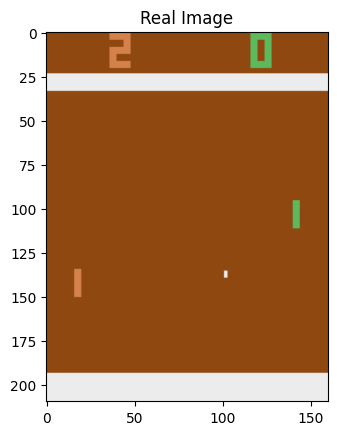

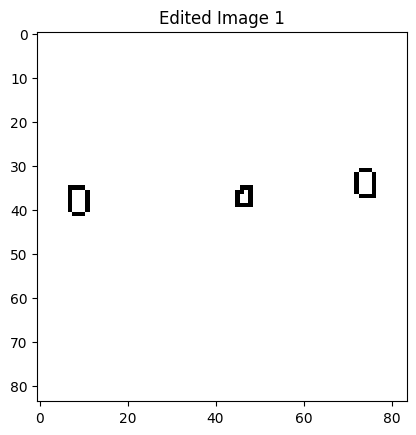

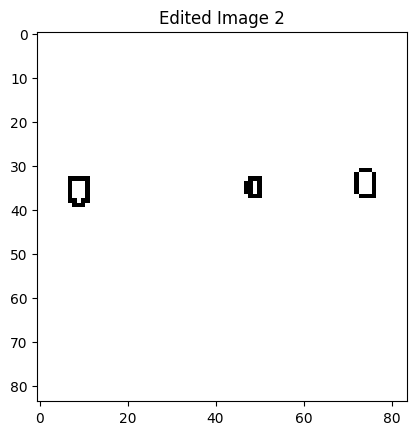

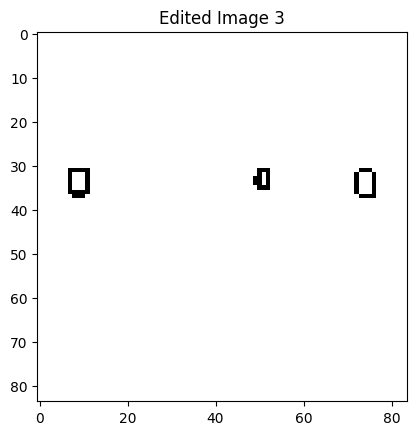

In [14]:
agent.show_screen()

In [ ]:
agent.train()

Episode:     10 | MA50:  -21.0 | Episode Reward:  -21.0 | Steps:   764 | Actions: [124. 107. 116. 144. 126. 147.]
Saving model to Pong/, best episode score: -19.0
Episode:     20 | MA50:  -20.0 | Episode Reward:  -19.0 | Steps:   954 | Actions: [ 98.  47. 221. 124. 171. 293.]
Episode:     30 | MA50:  -20.3 | Episode Reward:  -21.0 | Steps:   764 | Actions: [ 45.  11.  27.  14.  19. 648.]
Episode:     40 | MA50:  -20.2 | Episode Reward:  -20.0 | Steps:   842 | Actions: [131.  50. 182.  51.  86. 342.]
Episode:     50 | MA50:  -20.4 | Episode Reward:  -21.0 | Steps:   764 | Actions: [141.  37. 240.  15.  38. 293.]
Episode:     60 | MA50:  -20.5 | Episode Reward:  -21.0 | Steps:   764 | Actions: [ 94.  64.  96.  18.  16. 476.]
Saving model to Pong/, best episode score: -19.0
Episode:     70 | MA50:  -20.3 | Episode Reward:  -19.0 | Steps:  1024 | Actions: [254. 233. 199.  47.  29. 262.]
Episode:     80 | MA50:  -20.4 | Episode Reward:  -21.0 | Steps:   764 | Actions: [222. 252.  80.  21.  

Episode:    730 | MA50:  -20.2 | Episode Reward:  -21.0 | Steps:   764 | Actions: [121. 139.  55. 154. 152. 143.]
Episode:    740 | MA50:  -20.2 | Episode Reward:  -21.0 | Steps:   854 | Actions: [162. 170.  64. 191. 159. 108.]
Episode:    750 | MA50:  -20.2 | Episode Reward:  -21.0 | Steps:   905 | Actions: [109. 166.  79. 247. 177. 127.]
Episode:    760 | MA50:  -20.2 | Episode Reward:  -20.0 | Steps:  1086 | Actions: [149. 202. 129. 196. 233. 177.]
Episode:    770 | MA50:  -20.2 | Episode Reward:  -20.0 | Steps:   949 | Actions: [ 82. 120. 177.  85. 205. 280.]
Episode:    780 | MA50:  -20.2 | Episode Reward:  -20.0 | Steps:   980 | Actions: [102. 215. 123. 176. 179. 185.]
Episode:    790 | MA50:  -20.2 | Episode Reward:  -21.0 | Steps:   764 | Actions: [ 88. 155. 115. 133. 121. 152.]
Episode:    800 | MA50:  -20.2 | Episode Reward:  -19.0 | Steps:   954 | Actions: [ 90. 176. 119. 165. 202. 202.]
Episode:    810 | MA50:  -20.2 | Episode Reward:  -21.0 | Steps:   850 | Actions: [124. 

Episode:   1390 | MA50:   -2.8 | Episode Reward:   19.0 | Steps:  1883 | Actions: [377. 265. 395. 287. 272. 287.]
Episode:   1400 | MA50:   -2.0 | Episode Reward:   20.0 | Steps:  1843 | Actions: [336. 202. 336. 309. 403. 257.]
Episode:   1410 | MA50:   -1.3 | Episode Reward:   19.0 | Steps:  2915 | Actions: [399. 314. 367. 769. 520. 546.]
Saving model to Pong/, best episode score: 21.0
Episode:   1420 | MA50:   -0.5 | Episode Reward:   21.0 | Steps:  2795 | Actions: [381. 329. 423. 599. 428. 635.]
Episode:   1430 | MA50:   +0.3 | Episode Reward:   18.0 | Steps:  2471 | Actions: [326. 365. 478. 528. 334. 440.]
Episode:   1440 | MA50:   +1.0 | Episode Reward:   20.0 | Steps:  2768 | Actions: [459. 361. 435. 550. 361. 602.]
Episode:   1450 | MA50:   +1.7 | Episode Reward:   16.0 | Steps:  2171 | Actions: [283. 341. 382. 340. 346. 479.]
Episode:   1460 | MA50:   +2.5 | Episode Reward:   20.0 | Steps:  2827 | Actions: [371. 349. 464. 549. 511. 583.]
Episode:   1470 | MA50:   +3.3 | Episode

Episode:   2040 | MA50:  +19.4 | Episode Reward:   20.0 | Steps:  1574 | Actions: [305. 203. 341. 183. 291. 251.]
Saving model to Pong/, best episode score: 21.0
Episode:   2050 | MA50:  +19.4 | Episode Reward:   21.0 | Steps:  1539 | Actions: [231. 259. 354. 195. 288. 212.]
Episode:   2060 | MA50:  +19.5 | Episode Reward:   20.0 | Steps:  1574 | Actions: [251. 309. 355. 141. 300. 218.]
Saving model to Pong/, best episode score: 21.0
Episode:   2070 | MA50:  +19.6 | Episode Reward:   21.0 | Steps:  1539 | Actions: [278. 331. 290. 191. 248. 201.]
Episode:   2080 | MA50:  +19.7 | Episode Reward:   20.0 | Steps:  1607 | Actions: [200. 313. 400. 184. 312. 198.]
Saving model to Pong/, best episode score: 21.0
Episode:   2090 | MA50:  +19.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [211. 239. 409. 215. 256. 209.]
Saving model to Pong/, best episode score: 21.0
Episode:   2100 | MA50:  +19.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [185. 262. 415. 224. 214. 239.]
Episode:  

Episode:   2610 | MA50:  +20.2 | Episode Reward:   19.0 | Steps:  1644 | Actions: [228. 252. 254. 202. 438. 270.]
Saving model to Pong/, best episode score: 21.0
Episode:   2620 | MA50:  +20.2 | Episode Reward:   21.0 | Steps:  1539 | Actions: [200. 273. 310. 190. 374. 192.]
Saving model to Pong/, best episode score: 21.0
Episode:   2630 | MA50:  +20.2 | Episode Reward:   21.0 | Steps:  1544 | Actions: [204. 236. 297. 188. 366. 253.]
Saving model to Pong/, best episode score: 21.0
Episode:   2640 | MA50:  +20.3 | Episode Reward:   21.0 | Steps:  1544 | Actions: [244. 226. 305. 180. 369. 220.]
Saving model to Pong/, best episode score: 21.0
Episode:   2650 | MA50:  +20.3 | Episode Reward:   21.0 | Steps:  1539 | Actions: [213. 250. 293. 187. 384. 212.]
Saving model to Pong/, best episode score: 21.0
Episode:   2660 | MA50:  +20.3 | Episode Reward:   21.0 | Steps:  1539 | Actions: [201. 249. 251. 188. 415. 235.]
Saving model to Pong/, best episode score: 21.0
Episode:   2670 | MA50:  +20

Saving model to Pong/, best episode score: 21.0
Episode:   3160 | MA50:  +20.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [244. 179. 321. 196. 358. 241.]
Episode:   3170 | MA50:  +20.7 | Episode Reward:   19.0 | Steps:  1637 | Actions: [253. 289. 341. 258. 286. 210.]
Saving model to Pong/, best episode score: 21.0
Episode:   3180 | MA50:  +20.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [292. 224. 299. 244. 264. 216.]
Episode:   3190 | MA50:  +20.7 | Episode Reward:   20.0 | Steps:  1625 | Actions: [347. 271. 290. 240. 280. 197.]
Saving model to Pong/, best episode score: 21.0
Episode:   3200 | MA50:  +20.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [248. 290. 382. 178. 237. 204.]
Saving model to Pong/, best episode score: 21.0
Episode:   3210 | MA50:  +20.7 | Episode Reward:   21.0 | Steps:  1539 | Actions: [217. 244. 326. 187. 324. 241.]
Saving model to Pong/, best episode score: 21.0
Episode:   3220 | MA50:  +20.7 | Episode Reward:   21.0 | Steps:  1539 | Act

Saving model to Pong/, best episode score: 21.0
Episode:   3710 | MA50:  +20.5 | Episode Reward:   21.0 | Steps:  1539 | Actions: [179. 247. 301. 230. 392. 190.]
Saving model to Pong/, best episode score: 21.0
Episode:   3720 | MA50:  +20.5 | Episode Reward:   21.0 | Steps:  1539 | Actions: [215. 269. 339. 187. 293. 236.]
Saving model to Pong/, best episode score: 21.0
Episode:   3730 | MA50:  +20.5 | Episode Reward:   21.0 | Steps:  1539 | Actions: [210. 276. 354. 172. 300. 227.]
Episode:   3740 | MA50:  +20.5 | Episode Reward:   20.0 | Steps:  1608 | Actions: [250. 231. 361. 254. 271. 241.]
Saving model to Pong/, best episode score: 21.0
Episode:   3750 | MA50:  +20.5 | Episode Reward:   21.0 | Steps:  1539 | Actions: [195. 204. 331. 211. 322. 276.]
Saving model to Pong/, best episode score: 21.0
Episode:   3760 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1659 | Actions: [347. 247. 266. 251. 309. 239.]
Saving model to Pong/, best episode score: 21.0
Episode:   3770 | MA50:  +20

Saving model to Pong/, best episode score: 21.0
Episode:   4260 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1539 | Actions: [269. 254. 284. 218. 294. 220.]
Saving model to Pong/, best episode score: 21.0
Episode:   4270 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1599 | Actions: [206. 216. 299. 279. 314. 285.]
Saving model to Pong/, best episode score: 21.0
Episode:   4280 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1599 | Actions: [286. 210. 326. 249. 266. 262.]
Episode:   4290 | MA50:  +20.5 | Episode Reward:   19.0 | Steps:  1636 | Actions: [337. 208. 306. 233. 257. 295.]
Saving model to Pong/, best episode score: 21.0
Episode:   4300 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1539 | Actions: [301. 190. 286. 217. 287. 258.]
Episode:   4310 | MA50:  +20.6 | Episode Reward:   20.0 | Steps:  1574 | Actions: [281. 211. 285. 250. 277. 270.]
Saving model to Pong/, best episode score: 21.0
Episode:   4320 | MA50:  +20.6 | Episode Reward:   21.0 | Steps:  1539 | Act

In [ ]:
agent.plot()